In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [213]:
from fastai.structured import *
from fastai.column_data import *
import operator
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [3]:
PATH='data/grainprices/'

## Gather weather data ##

### Download data ###
Don't need to do this more than once

In [4]:
import requests
tavg_url = 'https://www.ncdc.noaa.gov/cag/statewide/time-series/%d-tavg-all-1-1895-2018.csv?base_prd=true&begbaseyear=1895&endbaseyear=2018'
pcp_url = 'https://www.ncdc.noaa.gov/cag/statewide/time-series/%d-pcp-all-1-1895-2018.csv?base_prd=true&begbaseyear=1895&endbaseyear=2018'
mean_temp_dir = f'{PATH}weather/mean_temp'
pcp_dir = f'{PATH}weather/pcp'
if not os.path.exists(f'{PATH}weather'):
    os.mkdir(f'{PATH}weather')
    os.mkdir(pcp_dir)
    os.mkdir(mean_temp_dir)
    
def get_url_for_states(url, file_path):
    state = 1
    while True:
        r = requests.get(url % state)
        if r.status_code != 200:
            break
        fn = r.content.split(b',')[0].decode('utf-8')
        with open(file_path % fn, 'wb') as f:  
            f.write(b'\n'.join(r.content.splitlines()[4:]))
        r.close()
        state += 1

get_url_for_states(tavg_url, f'{mean_temp_dir}/%s.csv')
get_url_for_states(pcp_url, f'{pcp_dir}/%s.csv')
    

### Process Data in Dataframe ###

In [32]:
def construct_df_from_dir(path, value_name):
    df = None
    for fn in os.listdir(mean_temp_dir):
        state = fn.split('.')[0].upper()
        df_state = pd.read_csv(f'{path}/{fn}')

        df_ed = df_state.Date.astype(str).str
        df_state['Year'] = df_ed[0:4].astype('int32')
        df_state['Month'] = df_ed[4:].astype('int32')
        df_state['State'] = state
        df_state.rename(columns={'Value': value_name}, inplace=True)
        df_state.drop(columns=['Anomaly', 'Date'], inplace=True)
        if df is None:
            df = df_state
        else:
            df = df.append(df_state)
    return df

mt_df = construct_df_from_dir(mean_temp_dir, 'MeanTemp')
pcp_df = construct_df_from_dir(pcp_dir, 'Precipitation').set_index(['State', 'Year', 'Month'])

weather_df = mt_df.join(pcp_df, how='left', on=['State', 'Year', 'Month'], rsuffix = '_').set_index(['State', 'Year', 'Month'])
weather_df.reset_index().to_feather(f'{PATH}weather_df')

## Prepare Grain Price Dataframe ##

In [149]:
df = pd.read_csv(f'{PATH}monthly_state_grain_prices.csv', na_values=(' (D)', ' (S)'))
df.drop(['Program', 'Week Ending', 'State ANSI', 'Ag District', 'Ag District Code', 'County', 'County ANSI', 'Zip Code', 'Geo Level', 'Region', 'Domain', 'watershed_code', 'Watershed', 'Commodity', 'Data Item', 'Domain Category', 'CV (%)'], axis=1, inplace=True)
df = df.rename(columns={'Period': 'Month'})
df = df[pd.notnull(df['Value'])].infer_objects()

In [150]:
month_to_num = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
df.Month = df.Month.apply(lambda month: month_to_num[month])
df = df.reset_index(drop=True)
df = df.join(weather_df, how='left', on=['State', 'Year', 'Month'], rsuffix = '_')

Add lag column for precipitation, this step seems to take a while

In [151]:
def calc_lag_vals(df, col_name, new_col_name):
    lag_vals = []
    for month, year, state in zip(df.Month, df.Year, df.State):
        last_month = None
        targ_year = year
        if (month == 1):
            last_month = 12
            targ_year = year - 1
        else:
            last_month = month - 1
        tmp_df = df[(df.State == state) & (df.Month == last_month) & (df.Year == targ_year)]
        lag_val = None
        if len(tmp_df) == 1:
            lag_val = tmp_df[col_name].iloc[0]
        lag_vals.append(lag_val)
    df[new_col_name] = lag_vals
    df.dropna(subset=[new_col_name], inplace=True)

       Year  Month           State  Value  MeanTemp  Precipitation  \
0      2018      1        COLORADO   3.62      29.8           0.81   
1      2018      1           IDAHO   4.68      30.5           2.80   
2      2018      1        ILLINOIS   5.08      24.1           1.29   
4      2018      1          KANSAS   3.94      29.8           0.39   
5      2018      1        MICHIGAN   4.43      20.0           1.74   
6      2018      1       MINNESOTA   5.75      10.4           0.56   
7      2018      1        MISSOURI   4.69      28.1           1.64   
8      2018      1         MONTANA   5.34      21.7           1.15   
9      2018      1        NEBRASKA   3.62      23.1           0.72   
10     2018      1  NORTH CAROLINA   5.11      35.8           3.77   
11     2018      1    NORTH DAKOTA   5.73      11.8           0.23   
12     2018      1            OHIO   4.52      25.0           2.31   
13     2018      1        OKLAHOMA   3.81      36.7           0.53   
14     2018      1  

In [152]:
df.reset_index(inplace=True, drop=True)
df.to_feather(f'{PATH}lagged')

### Preprocessing Checkpoint ###

In [9]:
df = pd.read_feather(f'{PATH}lagged')

In [11]:
dates = []
for year, month in zip(df.Year.values, df.Month.values):
    dt = datetime.datetime(year, month, 1)
    dates.append(dt)
df['Date'] = dates
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')

In [12]:
cat_vars = ['Year', 'Month', 'State']
contin_vars = ['MeanTemp', 'Precipitation', 'PrecipitationLag1']
dep = 'Value'

In [13]:
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()

for v in contin_vars:
    df[v] = df[v].astype('float32')

In [15]:
df.sort_index(inplace=True)

In [224]:
df

,Year,Month,State,Value,MeanTemp,Precipitation,PrecipitationLag1
Date,,,,,,,
1908-02-01,1908,2,IDAHO,0.84,27.400000,1.60,1.48
1908-02-01,1908,2,ALABAMA,1.03,44.000000,6.87,4.19
1908-03-01,1908,3,IDAHO,0.93,32.900002,1.77,1.60
1908-03-01,1908,3,ALABAMA,1.01,62.200001,4.70,6.87
1908-04-01,1908,4,ALABAMA,1.02,67.400002,6.30,4.70
1908-04-01,1908,4,IDAHO,1.00,43.200001,1.09,1.77
1908-05-01,1908,5,ALABAMA,1.05,71.800003,5.50,6.30
1908-05-01,1908,5,IDAHO,1.08,45.400002,3.27,1.09
1908-06-01,1908,6,ALABAMA,1.06,78.000000,3.34,5.50


### Process dataframe to prep it for training ###

In [40]:
df_sep, y, nas = proc_df(df, 'Value')
yl = np.log(y)

{}


In [207]:
train_ratio = 0.75
train_size = int(len(df_sep) * train_ratio)
val_idx = list(range(train_size, len(df_sep)))
len(df_sep) - len(df_sep)*0.75

Year                  1.00
Month                 2.00
State                 9.00
MeanTemp             27.40
Precipitation         1.60
PrecipitationLag1     1.48
Name: 1908-02-01 00:00:00, dtype: float32

In [18]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

## Build and Train a Neural Network Model ##

In [41]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df_sep, y.astype(np.float32), cat_flds=cat_vars, bs=128)

 48%|████▊     | 69/145 [00:01<00:02, 35.47it/s, loss=6.73]


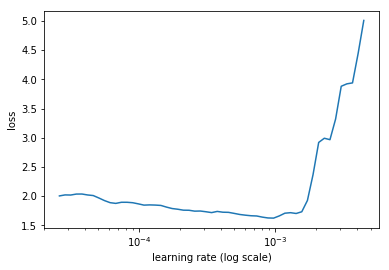

In [63]:
learn = md.get_learner([(112,50), (13, 7), (43, 22)], len(df_sep.columns) - len(cat_vars), 0.4, 1, [1000, 500], [0.001, 0.01])
learn.lr_find()
learn.sched.plot()

In [195]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss                               
    0      0.31544    8.881384  
    1      0.160009   8.860723                               
    2      0.145817   9.048586                               



[array([9.04859])]

## Visualizations of the Model ##

In [66]:
df_state = df_sep[df_sep.State == 9]
cat = df_state[['Year', 'Month', 'State']]
cont = df_state[['MeanTemp', 'Precipitation', 'PrecipitationLag1']]

In [67]:
learn.model.eval()
pred = to_np(learn.model(to_gpu(V(T(np.array(cat.values)))), to_gpu(V(T(np.array(cont.values))))))

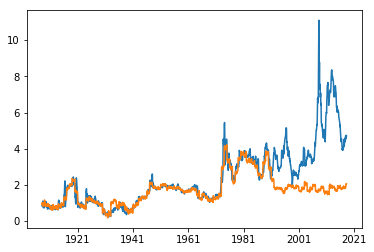

In [69]:
df_actuals = df[df.State == df.State.cat.categories[8]]
actuals = df_actuals[['Value']].values
matplotlib.pyplot.plot(df_actuals.index.values, actuals)
matplotlib.pyplot.plot(df_actuals.index.values, pred)

## Random Forest ##

In [234]:
df_rf = df_sep.iloc[0:train_size]
y_rf = y[0:train_size]
rfr = RandomForestRegressor(n_estimators=10, n_jobs=-1)
rfr.fit(df_rf, y_rf)
rfr.score(df_sep.iloc[train_size:], y[train_size:])
# preds_rfr = rfr.predict(df_sep[df_sep.State == 9])
# matplotlib.pyplot.plot(df_actuals.index.values, actuals)
# matplotlib.pyplot.plot(df_actuals.index.values, preds_rfr)

-1.2267791799134327

In [236]:
rf_feat_importance(rfr, df_rf)

,cols,imp
0,Year,0.902191
1,Month,0.058986
2,State,0.013346
3,MeanTemp,0.009659
5,PrecipitationLag1,0.008275
4,Precipitation,0.007544


## Try again with the State with the most data ##

In [173]:
max_state = max(df_sep.State.value_counts().iteritems(), key=operator.itemgetter(1))[0]
df_st = df[df.State == df.State.cat.categories[max_state-1]]
print(len(df_st))
cat_vars = ['Year', 'Month']
contin_vars = ['MeanTemp', 'Precipitation', 'PrecipitationLag1']

1318


In [114]:
df_sep_st, y_st, nas_st = proc_df(df_st, 'Value', skip_flds=['State'])
yl_st = np.log(y_st)

/Users/danielharrison/Documents/fastai_fork/fastai/courses/dl1/fastai/structured.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.drop(ignore_flds, axis=1, inplace=True)


In [168]:
train_ratio_st = 0.80
train_size_st = int(len(df_sep_st) * train_ratio_st)
val_idx_st = list(range(train_size_st, len(df_sep_st)))
df_sep_st.get(train_size_st)

In [155]:
max_log_y_st = np.max(yl_st)
y_range_st = (0, max_log_y_st*1.2)

In [156]:
md_st = ColumnarModelData.from_data_frame(PATH, val_idx_st, df_sep_st, y_st.astype(np.float32), cat_flds=cat_vars, bs=10)

 40%|███▉      | 42/106 [00:00<00:01, 57.41it/s, loss=9.19]


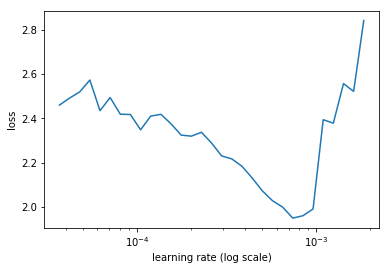

In [157]:
learn_st = md_st.get_learner([(112,50), (13, 7)], len(df_sep_st.columns) - len(cat_vars), 0.4, 1, [1000, 500], [0.001, 0.01])
learn_st.lr_find()
learn_st.sched.plot()

In [158]:
learn_st.fit(1e-2, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   exp_rmspe                  
    0      12.134318  12.710815  0.879688  
    1      1.603828   13.061998  0.886655                   
    2      0.41246    12.67706   0.880718                    



[array([12.67706]), 0.8807181435075042]

In [160]:
cat = df_sep_st[['Year', 'Month']]
cont = df_sep_st[['MeanTemp', 'Precipitation', 'PrecipitationLag1']]

In [161]:
learn_st.model.eval()
pred = to_np(learn_st.model(to_gpu(V(T(np.array(cat.values)))), to_gpu(V(T(np.array(cont.values))))))

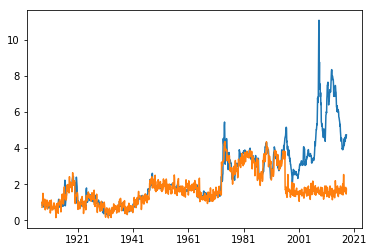

In [163]:
matplotlib.pyplot.plot(df_sep_st.index.values, y_st)
matplotlib.pyplot.plot(df_sep_st.index.values, pred)

## Try again again with Year removed ##

In [194]:
max_state = max(df_sep.State.value_counts().iteritems(), key=operator.itemgetter(1))[0]
df_st = df[df.State == df.State.cat.categories[max_state-1]]
print(len(df_st))
cat_vars = ['Month']
contin_vars = ['MeanTemp', 'Precipitation', 'PrecipitationLag1']

1318


'IDAHO'

In [185]:
df_sep_st, y_st, nas_st = proc_df(df_st, 'Value', skip_flds=['State', 'Year'])
yl_st = np.log(y_st)

/Users/danielharrison/Documents/fastai_fork/fastai/courses/dl1/fastai/structured.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.drop(ignore_flds, axis=1, inplace=True)


In [186]:
train_ratio_st = 0.80
train_size_st = int(len(df_sep_st) * train_ratio_st)
val_idx_st = list(range(train_size_st, len(df_sep_st)))
df_sep_st.get(train_size_st)

In [187]:
max_log_y_st = np.max(yl_st)
y_range_st = (0, max_log_y_st*1.2)

In [188]:
md_st = ColumnarModelData.from_data_frame(PATH, val_idx_st, df_sep_st, y_st.astype(np.float32), cat_flds=cat_vars, bs=10)

 45%|████▌     | 48/106 [00:00<00:00, 62.28it/s, loss=17]  


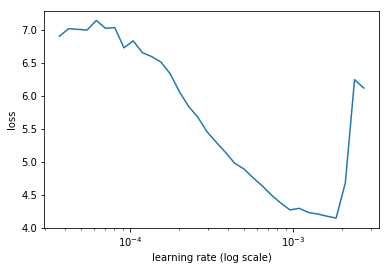

In [189]:
learn_st = md_st.get_learner([(13, 7)], len(df_sep_st.columns) - len(cat_vars), 0.4, 1, [1000, 500], [0.001, 0.01])
learn_st.lr_find()
learn_st.sched.plot()

In [190]:
learn_st.fit(1e-3, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   exp_rmspe                 
    0      14.973221  11.161714  0.847337  
    1      3.180739   9.998316   0.819283                   
    2      1.957202   10.398096  0.82871                    



[array([10.3981]), 0.8287101013654772]

In [191]:
cat = df_sep_st[['Month']]
cont = df_sep_st[['MeanTemp', 'Precipitation', 'PrecipitationLag1']]

In [192]:
learn_st.model.eval()
pred = to_np(learn_st.model(to_gpu(V(T(np.array(cat.values)))), to_gpu(V(T(np.array(cont.values))))))

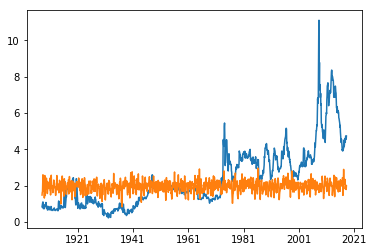

In [193]:
matplotlib.pyplot.plot(df_sep_st.index.values, y_st)
matplotlib.pyplot.plot(df_sep_st.index.values, pred)

## Feature Engineering is Hard ##

Based on this model's performance, Precipitation and Mean Temperature are likely not big factors at play for determining grain prices. Just looking at the graphs above (for Idaho I believe) we could probably gather from the behavior of wheat prices in the past 40 years that something more than precipitation and temperature is causing large spikes and a lot of volatility. Could maybe add more economy related data (stock prices, gas prices, inflation, dollar value) and industry data (production of wheat, number of farmers, acres of farmland, soil data, ...)